## Scania data: APS Failure and Operational Data for Scania Trucks

 The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the <br>
 Air Pressure system (APS) which generates pressurised air that are utilized in various functions in a truck, <br>
 such as braking and gear changes. The datasets' positive class consists of component failures <br>
 for a specific component of the APS system. The negative class consists of trucks with failures<br> 
 for components not related to the APS. The data consists of a subset of all available data, selected by experts. <br>

- Challenge metric  

     Cost-metric of miss-classification:

     Predicted class |      True class       |
                     |    pos    |    neg    |
     -----------------------------------------
      pos            |     -     |  Cost_1   |
     -----------------------------------------
      neg            |  Cost_2   |     -     |
     -----------------------------------------
     Cost_1 = 10 and cost_2 = 500

     The total cost of a prediction model the sum of "Cost_1" 
     multiplied by the number of Instances with type 1 failure 
     and "Cost_2" with the number of instances with type 2 failure, 
     resulting in a "Total_cost".

     In this case Cost_1 refers to the cost that an unnessecary 
     check needs to be done by an mechanic at an workshop, while 
     Cost_2 refer to the cost of missing a faulty truck, 
     which may cause a breakdown.

     Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.


In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import TransformerMixin
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.feature_selection import VarianceThreshold,SelectFromModel, RFE, RFECV
from scipy.stats.distributions import uniform, randint

### Loading and looking at data

Skipping first 20 rows as they are description of data and not actual data that we are interested in

In [11]:
aps_train = pd.read_csv('aps_failure_training_set.csv', skiprows=20, error_bad_lines=False)
aps_test = pd.read_csv('aps_failure_test_set.csv', skiprows=20, error_bad_lines=False)

In [12]:
aps_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [13]:
aps_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


The colum names are not informative, so I will have to dive deeper and see their distributions, missing values ect. to build some intuition connected with data and features available.<br>

'Class' column is the target. I will binarize it.<br>
Besides I will convert 'na' string (this is how missing data is encoded) to np.nan <br>


In [14]:
aps_train['class'].unique()

array(['neg', 'pos'], dtype=object)

In [15]:
aps_train['class'] = aps_train['class'].map({'neg':0,'pos':1})
aps_test['class'] = aps_test['class'].map({'neg':0,'pos':1})

In [16]:
aps_train.replace('na',np.nan, inplace = True)
aps_test.replace('na',np.nan, inplace = True)

### Target value

In [17]:
aps_train['class'].mean() 

0.016666666666666666

Target is highly imbalanced: 1,6% of positives in dataset

In [18]:
np.sum(aps_train['class'])

1000

### Checking missing values

In [19]:
### col_nans - np.nan as a % of all instances
col_nans = np.sum(aps_train.isnull(),axis=0).sort_values(ascending = False)/aps_train.shape[0]

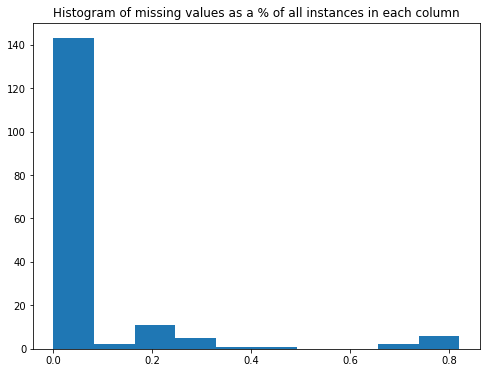

In [20]:
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(col_nans)
ax.set_title('Histogram of missing values as a % of all instances in each column')
plt.show()

Most of the columns have ratio of missing values below 10% of the data. For the baseline model I will just encode them. At the later stage I may set some threshold to delete cols with very high nans ratio

### Looking at numerical variables


According to documentation, all variables are numerical. I will check how are they represented in data frame

In [21]:
aps_train.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

I will convert all features to numeric type

In [22]:
aps_train.iloc[:,1:] = aps_train.iloc[:,1:].astype('float')

In [23]:
aps_train.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0


### Let' s look at the distribution of all features briefly:

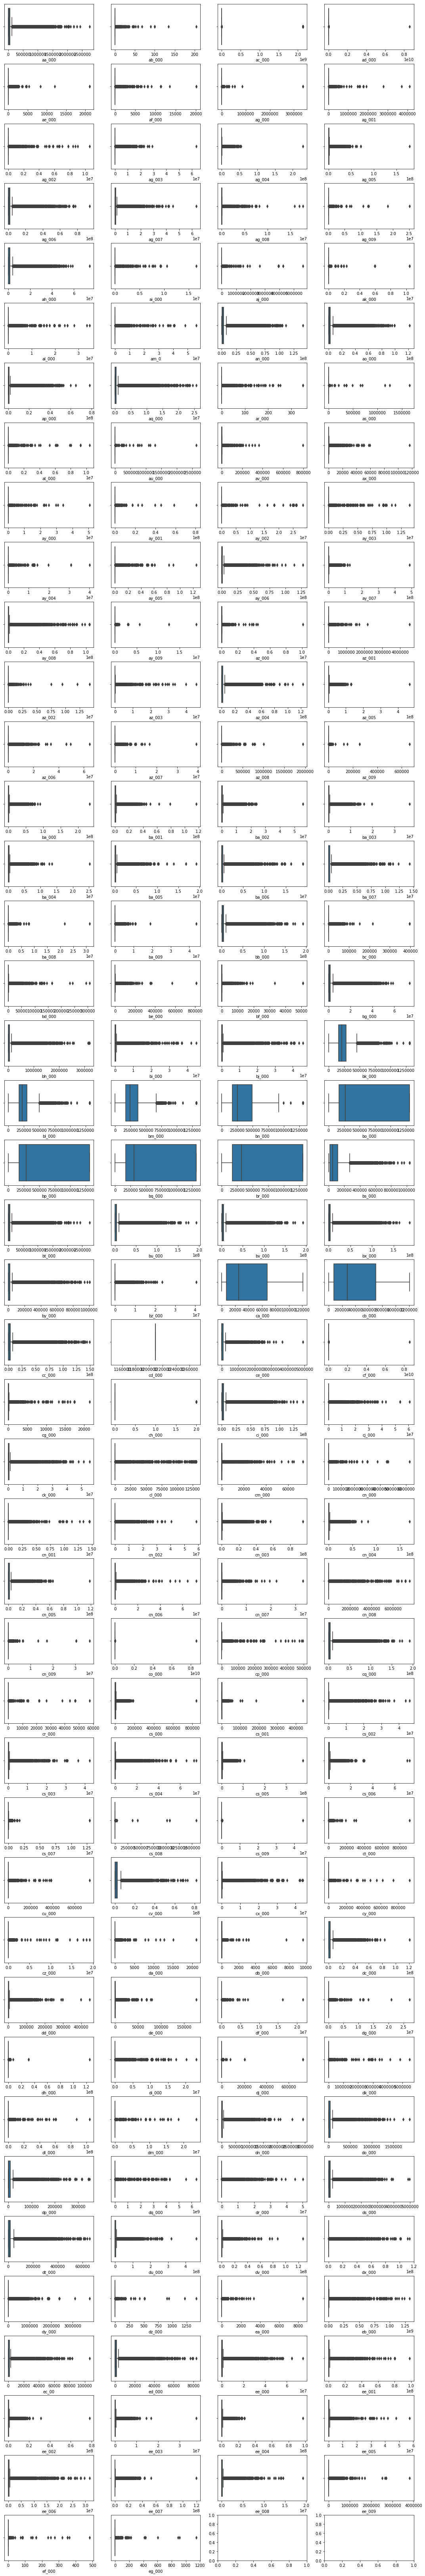

In [369]:
rows = (len(aps_train.columns)//4+1)
cols = 4        


fig, axs =  plt.subplots(rows,cols,figsize = (15,90))
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=1.5) #useful trick 


aps_col_idx = 1 #starting from index 1 (from first feature)
for row in range(rows):
    for col in range(cols):
            if aps_col_idx < len(aps_train.columns):
                sns.boxplot(aps_train.iloc[:,aps_col_idx], ax = axs[row,col])
                aps_col_idx +=1
            else:
                pass

plt.show()

As we can see almost all variables are highly right-skewed. XGBoost Classifier will handle it well, for linear models I would transform data using log transformation or Box-Cox transformation.

### Let' s see whether features are correlated with each other:

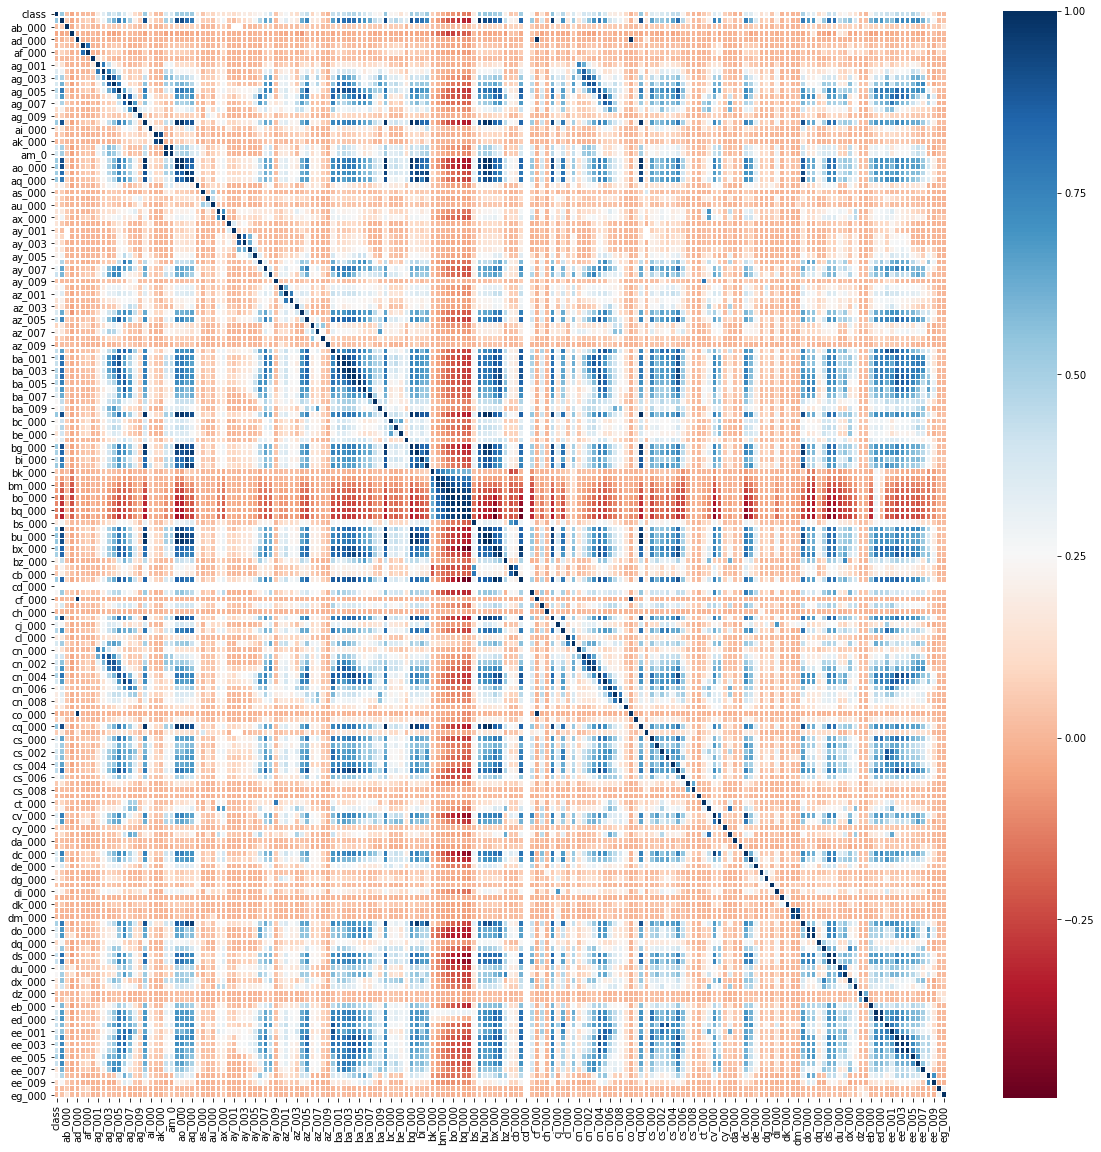

In [173]:
fig, ax =plt.subplots(figsize=(25,20))
sns.heatmap(aps_train.corr(),linewidths=0.5,cmap = 'RdBu',ax = ax)
plt.show()

As we can see from the plot above there are lots of features that are highly correlated with other (such a situation can hinder the model performance - possible solutions of feature selection are principal component analysis, recursive feature elimination or implicitly by l1 regularization. It will be addressed later.

### Encoding missing values using own defined transformer:
Fist I will check which value is not represented in the model

In [370]:
set(np.min(aps_train))

{0.0, 172.0, 1209600.0}

In [371]:
class MissingValsImputer(TransformerMixin):
    '''works for pandas dataframes'''
    
    def __init__(self,to_impute):
        self.to_impute = to_impute
        
    def fit(self,df):
        return self
    
    def transform(self,df):
        
        df = df.copy()
        df[pd.isnull(df)] = self.to_impute
        return df

I will use -1 to encode n/a

In [372]:
MVI = MissingValsImputer(-1)
aps_train_base = MVI.fit_transform(aps_train)


### Creating own scoring function:
As we can see in this description of the dataset, we need to set own scoring function, where type I error costs 10 and type II error cost equals 500. Goal is to minimize total cost

In [373]:
def score_function(true_labels, predicted_labels):
    errors = true_labels - predicted_labels
    
    costs = [-500 if item == 1 else -10 if item == -1 else 0 for item in errors]  
    total_cost = sum(costs)
    
    return total_cost

In [433]:
score_scania = make_scorer(score_function, greater_is_better=True)

Let's see how it works (scorer means that the greater is the function the better):

In [434]:
true_labels = np.array([1,1,1,0,1,1])
predicted_labels = np.array([0,0,1,1,1,1])

In [435]:
score_function(true_labels,predicted_labels)

-1010

It works as expected - 2 false negatives (- 2x500) and 1 false positive (- 1 x 10). Together it gives -1010

-----------------------

### XGboost baseline classifier:
I will construct the XGboost classifier using default options to have a base to compare more optimized models.

In [100]:
?XGBClassifier

Train, test split:

In [334]:
X = aps_train_base.iloc[:,1:]
y = aps_train_base.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 211)



In [335]:
XGBoost_search = GridSearchCV (
                                  estimator = XGBClassifier(n_jobs=4, nthread=4),
                                  cv = StratifiedKFold(n_splits=3, shuffle= True),
                                  param_grid = {},
                                  scoring = 'roc_auc'
                                                     )

In [336]:
XGBoost_base = XGBoost_search.fit(X_train, y_train)

Below the set of important features chosen by XGBoost Classifier

In [337]:
XGBoost_base.best_estimator_.feature_importances_

array([ 0.04637681,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01304348,  0.03188406,  0.00289855,
        0.00869565,  0.00724638,  0.0057971 ,  0.00289855,  0.        ,
        0.00144928,  0.00289855,  0.01884058,  0.00724638,  0.        ,
        0.01884058,  0.03623188,  0.00144928,  0.01449275,  0.        ,
        0.0173913 ,  0.        ,  0.        ,  0.00144928,  0.        ,
        0.00144928,  0.00144928,  0.01594203,  0.0057971 ,  0.01594203,
        0.01449275,  0.00144928,  0.03913043,  0.04347826,  0.00724638,
        0.03478261,  0.01014493,  0.01014493,  0.00724638,  0.01014493,
        0.00434783,  0.00144928,  0.        ,  0.00434783,  0.00144928,
        0.        ,  0.        ,  0.00144928,  0.        ,  0.00434783,
        0.00144928,  0.        ,  0.00144928,  0.00289855,  0.00144928,
        0.00869565,  0.        ,  0.00144928,  0.01014493,  0.0057971 ,
        0.00144928,  0.00289855,  0.        ,  0.        ,  0.00

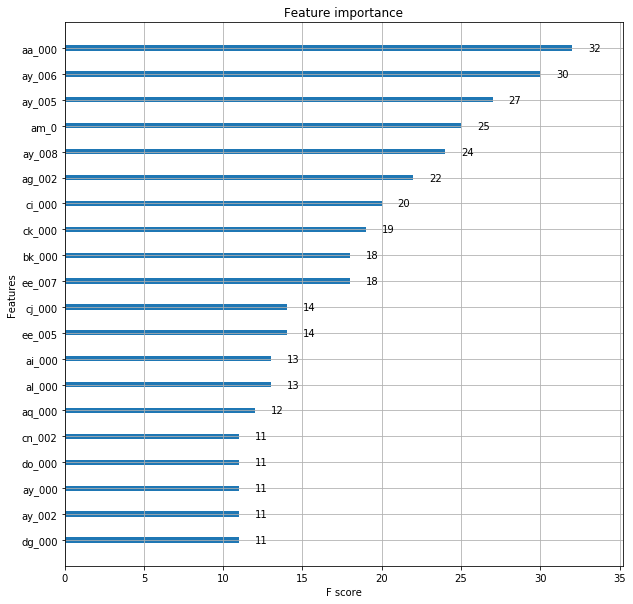

In [338]:
fig, ax = plt.subplots(figsize = (10,10))
plot_importance(XGBoost_base.best_estimator_, max_num_features = 20, ax = ax, importance_type =  "weight")
plt.show()

In [339]:
XGBoost_base.grid_scores_

C:\Python\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.98926, std: 0.00317, params: {}]

It achieves high roc_auc score with default parameters, let's now calculate score as stated in the description of the dataset

In [822]:
y_pred_base = XGBoost_base.best_estimator_.predict(X_test)

In [823]:
base_score = score_function(y_test, y_pred_base)
print('score equals:',base_score)

score equals: -40770


As we can see above the score is -40 770, let's see how it translates to no of type I and II errors

In [825]:
confusion_matrix(y_test, y_pred_base)

array([[14731,    27],
       [   81,   161]], dtype=int64)

Number of false negatives (which is painful for us when it comes to score) is quite high. In oder words the model was unable to predict 81 true positives (score: 81 x -500) and falsely predicted only 27 cases as positive (score: 27 x -10). We would like to inverse this numbers: we want our model to predict more positives even if it will make more type I errors. 

Setting lower threshold for probabilty to belong to class 1 will probably solve this issue (I will do this at the later stage)

-------------------------------------------------------------------------------------------------------------------------------

### Principal Component Analysis

precondition: feature scaling<br>
I will conduct PCA, because there are many highly correlated features in the dataset (as we could have seen from the correlation heatmap in the previous section)

In [362]:
scaler = StandardScaler()
X_train_sld = scaler.fit_transform(X_train)

In [363]:
pca = PCA()

In [364]:
pca.fit(X_train_sld)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

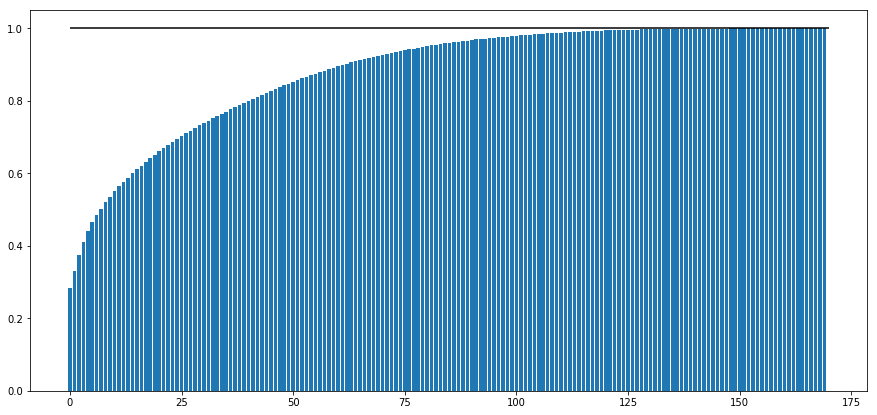

In [366]:
fig, ax = plt.subplots(figsize = (15,7))

ax.bar(range(pca.n_components_),np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 1, xmin = 0, xmax = X_train.shape[1])
plt.show()

We can see that some columns are very highly correlated with other and do not add too much variance. I can use PCA as a part of the modeling pipeline.  

-----------------

### XGboost optimized classifier:

preparing pipeline

In [758]:
pipe1 =  Pipeline([
                    ('scaler',StandardScaler()),
                    ('pca',PCA()),
                    ('xgb',XGBClassifier(silent = False, verbose = 1, n_jobs=4))
                    ])

In [759]:
param_dist = {
              'xgb__gamma':uniform(0,2),
              'xgb__max_depth':randint(2,5),
              'xgb__learning_rate':uniform(0.01, 0.5),
              'xgb__colsample_bytree':uniform(0.8, 0.2),
              'xgb__subsample':uniform(0.8, 0.2),
              'xgb__reg_alpha':uniform(0.5,1),
              'pca__n_components':randint(140, X_train.shape[1])
             }

This one will take a while (100 iterations):

In [760]:
rnd_search = RandomizedSearchCV(
                                estimator = pipe1,
                                cv = StratifiedKFold(3,shuffle=True),
                                param_distributions = param_dist,
                                n_iter = 100,
                                scoring = score_scania
                                )

In [761]:
XGBoost_opt = rnd_search.fit(X_train, y_train)

Let's see how the best train and test cv-score have been changing with subsequent iterations (defining function to do this)

In [835]:
mean_test_scores = XGBoost_opt.cv_results_['mean_test_score']

def max_scores_iter(mean_test_scores):

    max_score_lst = []
    max_score = np.min(mean_test_scores)

    for score in mean_test_scores:
        
        if score > max_score: 
            max_score = score
    
        max_score_lst.append(max_score)
                    
    return max_score_lst

In [849]:
mean_train_scores = XGBoost_opt.cv_results_['mean_train_score']

C:\Python\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


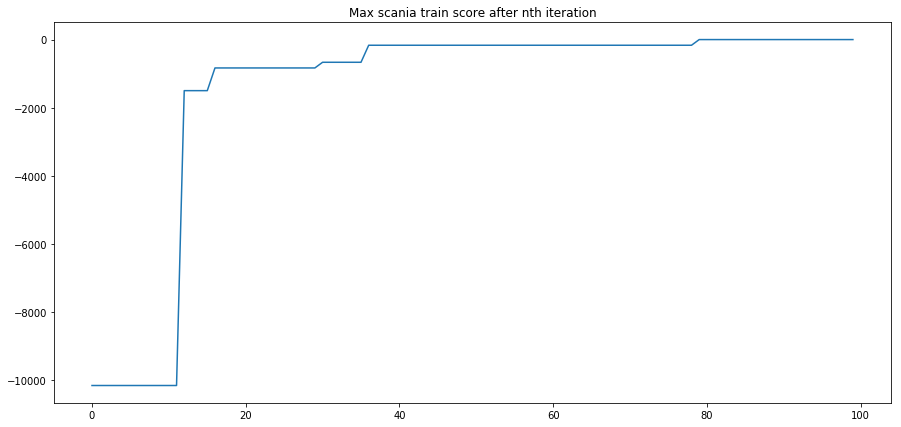

In [851]:
fig, ax = plt.subplots(figsize = (15,7))
ax.set_title('Max scania train score after nth iteration')
plt.plot(max_scores_iter(mean_train_scores))
plt.show()

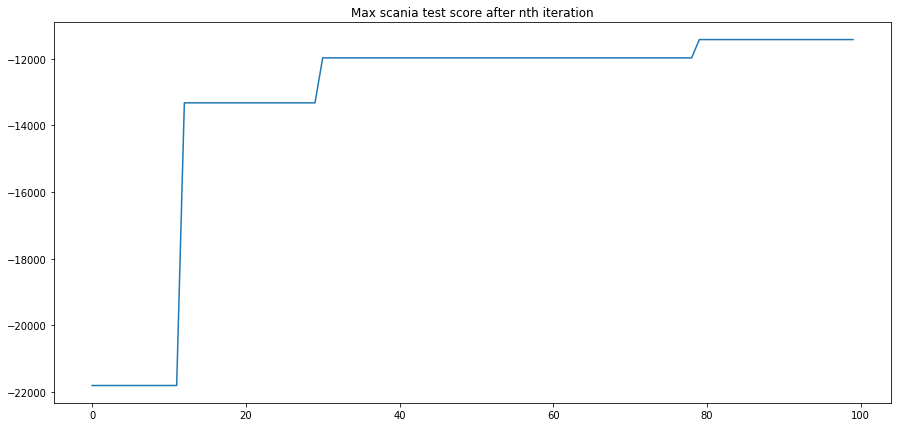

In [848]:
fig, ax = plt.subplots(figsize = (15,7))
ax.set_title('Max scania test score after nth iteration')
plt.plot(max_scores_iter(mean_test_scores))
plt.show()

In [838]:
XGBoost_opt.best_index_

79

The best model was found in RandomizedSearch at 79 iteration (for test score). For train score we can see that the model probably was overfitting in some parameter combinations

Let's see best parameters of the XGBoost:

In [852]:
XGBoost_opt.best_estimator_.get_params()['steps'][2][1].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.94476965143489156,
 'gamma': 0.042259456179933208,
 'learning_rate': 0.50127657030747697,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 1.0526962395522628,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': False,
 'subsample': 0.95555329534031286,
 'verbose': 1}

Now let's investigate test score for optimized parameters for XGBoost Classifier:

In [853]:
y_pred_opt = XGBoost_opt.best_estimator_.predict(X_test)

In [854]:
confusion_matrix(y_test, y_pred_opt)

array([[14656,   102],
       [   56,   186]], dtype=int64)

In [855]:
score_function(y_test, y_pred_opt)

-29020

#### Conclusion: 
Score is significantly higher in favour of optimized XGBoost Classifier (-29 020 vs. -40 770). We can see that the number of type II errors equals 56 and type I errors: 102. Still it would be beneficial to change the proportion of false positives and false negatives (i.e. score might be higher if we could be less conservative while assigning target to 1 class). We can do this by changing the decision threshold for the classifier (see below). I will also try SMOTE resampling method to increase the number of 1 class in the dataset:

-------------

### SMOTE sampling algorithm to increase no of 1's and chaning decision threshold:

inspiration for SMOTE: https://github.com/IBM/xgboost-smote-detect-fraud/blob/master/notebook/Fraud_Detection.ipynb

Installing package imblearn:

In [101]:
!pip install imblearn

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


I will increase the number of class 1 instances to 15 000 thousend

In [942]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=221, ratio={1:15000}) #increase the number of 1 to 15 000
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#### Perform Randomized Search on SMOTE resampled data:

In [944]:
rnd_search_res = RandomizedSearchCV(
                                estimator = pipe1,
                                cv = StratifiedKFold(3,shuffle=True),
                                param_distributions = param_dist,
                                n_iter = 70,
                                scoring = score_scania
                                )

In [945]:
XGBoost_opt_resampled = rnd_search_res.fit(X_train_res, y_train_res)

C:\Python\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


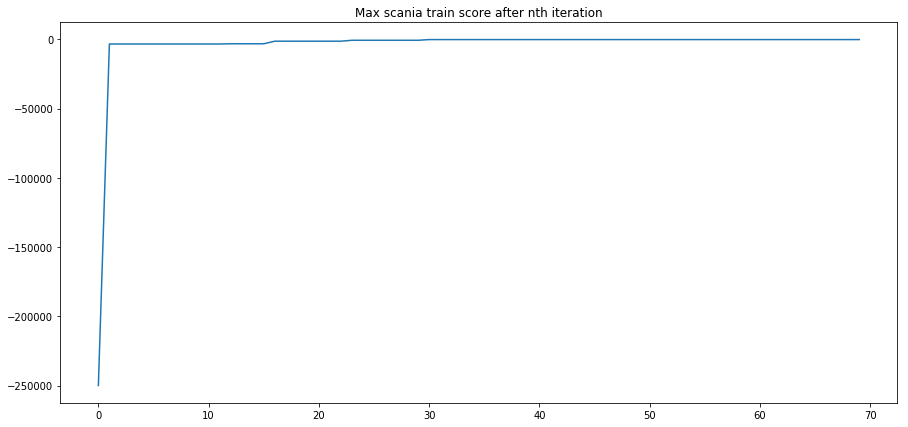

In [946]:
mean_train_scores_res = XGBoost_opt_resampled.cv_results_['mean_train_score']

fig, ax = plt.subplots(figsize = (15,7))
ax.set_title('Max scania train score after nth iteration')
plt.plot(max_scores_iter(mean_train_scores_res))
plt.show()

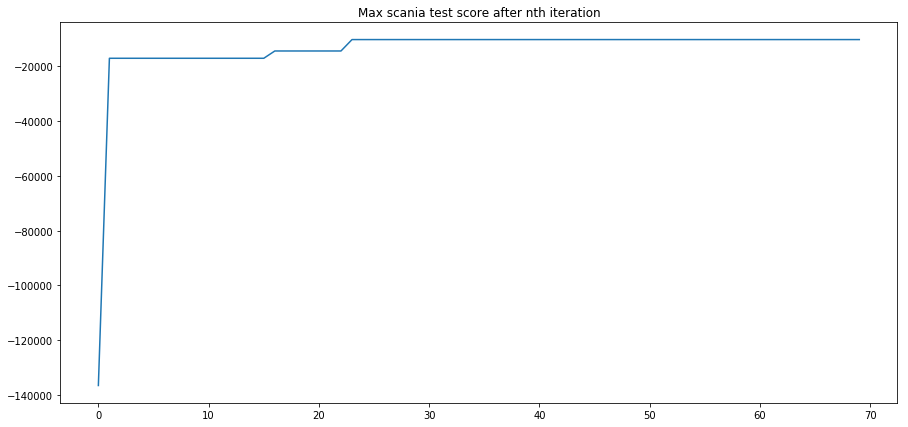

In [947]:
mean_test_scores_res = XGBoost_opt_resampled.cv_results_['mean_test_score']


fig, ax = plt.subplots(figsize = (15,7))
ax.set_title('Max scania test score after nth iteration')
plt.plot(max_scores_iter(mean_test_scores_res))
plt.show()

In [948]:
XGBoost_opt_resampled.best_estimator_.get_params()['steps'][2][1].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.84656531554743586,
 'gamma': 1.0073452698488634,
 'learning_rate': 0.41919587568743383,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 4,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.58100988621000182,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': False,
 'subsample': 0.88679390191078844,
 'verbose': 1}

In [949]:
y_pred_opt_resampled = XGBoost_opt_resampled.best_estimator_.predict(X_test)

In [950]:
confusion_matrix(y_test, y_pred_opt_resampled)

array([[14654,   104],
       [   58,   184]], dtype=int64)

In [951]:
score_function(y_test, y_pred_opt_resampled)

-30040

#### Conclusion for SMOTE: 
SMOTE did not improve the algorithm performance.<br>
Let's see how changing decision threshold will affect model

---------------------

### Changing decision threshold:

I will prepare grid to see which decision threshold maximizes score:

In [902]:
threshold_grid = np.arange(0.0,0.5,0.025)

In [903]:
threshold_grid

array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
        0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
        0.4  ,  0.425,  0.45 ,  0.475])

Simple function to test different decision thresholds and choose one, that maximizes the scania_function

In [908]:
def find_threshold(threshold_grid, estimator, X_test, y_test):
    
    max_score = -np.inf
    best_threshold = 0
    for idx, threshold in enumerate(threshold_grid):
        
        positive_class_prob = estimator.predict_proba(X_test)[:,1]
        y_pred = positive_class_prob > threshold
        
        score = score_function(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_threshold = threshold_grid[idx]
    
    y_pred_best =  positive_class_prob > best_threshold
    
    print(confusion_matrix(y_test,y_pred_best))    
    return best_threshold, max_score

In [912]:
best_threshold, best_score = find_threshold(threshold_grid, XGBoost_opt.best_estimator_, X_test, y_test)


[[14349   409]
 [   18   224]]


Best threshold found:

In [913]:
best_threshold

0.025000000000000001

Best score on test set:

In [914]:
best_score

-13090

In [926]:
best_model =XGBoost_opt.best_estimator_

Looks promising: let's apply this model with 0.025 threshold without SMOTE to unseen data <br>
First: imupting 'na' with -1 <br>
Second: separate features from labels <br>
Third: run model on dataset <br>

In [921]:
aps_test.iloc[:,1:]=aps_test.iloc[:,1:].astype('float')

In [922]:
aps_test_base = MVI.fit_transform(aps_test)

In [923]:
X_final = aps_test_base.iloc[:,1:]
y_final =  aps_test_base.iloc[:,0]

In [936]:
y_pred_final_prob =  best_model.predict_proba(X_final)
y_pred_final = y_pred_final_prob[:,1] > best_threshold

#### Confusion matrix on test set

In [938]:
confusion_matrix(y_final,y_pred_final)

array([[15235,   390],
       [   20,   355]], dtype=int64)

#### Final score on test set:

In [940]:
final_score = score_function(y_final,y_pred_final)

In [941]:
final_score

-13900

### Final conclusion:

The solution presented above was able to correctly predict 355 APS failures (out of total 375 true failures) and falsely predict 390 failures.<br> Total score was -13 900. Chaning decision threshold and optimizing XGBoost parameters had highest impact on score, whereas SMOTE resampling method did not improve model performance.

This project was interesting, beacause of large number of features, own-defined scoring, possibility to tackle real-life problem with highly imbalanced data. 